## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
798
+------------------+-----------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|          coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+-----------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
| 1811.159502467558|460.5274358673954|343.37546092364073|    493.5|SBBBBBSB| 48.8217|-100.4525|       SNWD|0.21585999994825408|0.16516195320429553|0.13697690891565673| 0.322776483888627

In [58]:
#extract longitude and latitude for each station
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_3|
+-----------+--------+---------+---------+-------------------+
|USC00320941| 48.8217|-100.4525|    493.5| 343.37546092364073|
|USC00320941| 48.8217|-100.4525|    493.5| -498.3505019652963|
|CA005010191|    49.3|   -99.45|    482.0|-1106.3804030213703|
|CA005010640|   49.55|   -99.08|    374.0|  514.1959210470644|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [59]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_3)
44,CA004011250,49.22,-101.75,515.0,3,493.070462
21,CA004012485,49.33,-101.45,511.0,7,-42.849560


In [63]:
pdf

,station,latitude,longitude,elevation,count(station),avg(coeff_3)
44,CA004011250,49.2200,-101.7500,515.0,3,493.070462
21,CA004012485,49.3300,-101.4500,511.0,7,-42.849560
33,CA004016521,49.6000,-101.7200,596.0,4,77.933429
42,CA004018960,49.4200,-102.5000,594.0,2,432.697026
22,CA005010191,49.3000,-99.4500,482.0,5,-829.513576
8,CA005010480,49.9170,-99.9500,409.0,7,-476.770544
34,CA005010485,49.8700,-99.9800,363.0,2,496.666768
45,CA005010640,49.5500,-99.0800,374.0,8,-433.628408
17,CA005010QFQ,49.9300,-101.2000,498.0,8,-79.522365
43,CA005012545,49.4500,-99.0200,403.0,5,-197.128650


In [60]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [61]:
# min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
min_lat,max_lat,min_long,max_long = box = (48, 50, -98.5, -103)


In [62]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]*10
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1000*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m


In [64]:
pdf

,station,latitude,longitude,elevation,count(station),avg(coeff_3)
44,CA004011250,49.2200,-101.7500,515.0,3,493.070462
21,CA004012485,49.3300,-101.4500,511.0,7,-42.849560
33,CA004016521,49.6000,-101.7200,596.0,4,77.933429
42,CA004018960,49.4200,-102.5000,594.0,2,432.697026
22,CA005010191,49.3000,-99.4500,482.0,5,-829.513576
8,CA005010480,49.9170,-99.9500,409.0,7,-476.770544
34,CA005010485,49.8700,-99.9800,363.0,2,496.666768
45,CA005010640,49.5500,-99.0800,374.0,8,-433.628408
17,CA005010QFQ,49.9300,-101.2000,498.0,8,-79.522365
43,CA005012545,49.4500,-99.0200,403.0,5,-197.128650


In [18]:
# Add legend in above map.

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [ ]:
# Not much correlation b/w avg. coeff_1 and elevation because not much difference in elevation.

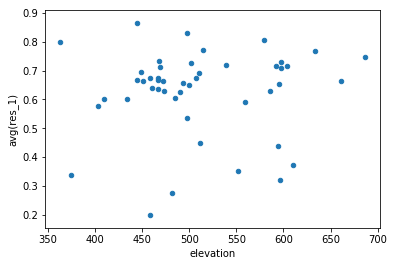

In [21]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(res_1)');